In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np


# Load all article reviews from MediaBiasChart V5.0:
media_bias = pd.read_csv('../data/MediaBiasChart.csv')
media_bias = media_bias.groupby('Source').mean()
media_bias.reset_index(level=0, inplace=True)

MediaBiasChart_to_Tweet = {'ABC':'ABC','AP':'AP','Axios':'axios','CNN':'CNN','Wall Street Journal':'WSJ',\
    'The Atlantic':'TheAtlantic','The Hill':'thehill', 'BBC':'BBC', 'Think Progress':'thinkprogress',\
    'MSNBC':'MSNBC','The Nation':'thenation','Daily Beast':'thedailybeast','Mother Jones':'MotherJones',\
    'CNSNews':'cnsnews','Fox News':'FoxNews', 'The Federalist':'FDRLST','Breitbart':'BreitbartNews',\
    'Daily Caller':'DailyCaller','The Blaze':'theblaze','Business Insider':'businessinsider',\
    'CBS':'CBSNews','The Economist':'TheEconomist','BuzzFeed':'BuzzFeed','Daily Signal':'DailySignal',\
    'New Republic':'newrepublic','Foreign Policy':'ForeignPolicy','IJR':'TheIJR','National Review':'NRO',\
    'National Public Radio':'NPR','New York Post':'nypost','New York Times':'nytimes','The New Yorker':'NewYorker',\
    'NewsMax':'newsmax','One America News Network':'OANN','Politico':'politico','Quartz':'qz',\
    'Reason':'reason','Reuters':'Reuters','Slate':'Slate','Talking Points Memo':'TPM','Vanity Fair':'VanityFair',\
    'Vox':'voxdotcom','Washington Examiner':'dcexaminer','Washington Free Beacon':'FreeBeacon',\
    'Washington Post':'washingtonpost','Washington Times':'WashTimes','The Week':'TheWeek','Bloomberg':'Bloomberg',\
    'Christian Science Monitor':'csmonitor', 'Democracy Now':'democracynow','Financial Times':'FT',\
    'Fiscal Times':'TheFiscalTimes','Forbes':'Forbes','Fortune':'FortuneMagazine','Forward':'jdforward',\
    'FreeSpeech TV':'freespeechtv','Huffington Post':'HuffPost','LA Times':'latimes','Marketwatch':'MarketWatch',\
    'OZY':'ozy','PBS':'PBS','ProPublica':'propublica','Time':'TIME','USA Today':'USATODAY',\
    'Weather.com':'weatherchannel'}

media_bias['Source'] = media_bias.Source.map(MediaBiasChart_to_Tweet)
media_bias = media_bias.dropna()
media_bias.reset_index(drop=True)


frac = 0.2  # This frac stands for the percentage of media to be selected as left/right media
left_bound = media_bias.Bias.quantile(frac)
right_bound = media_bias.Bias.quantile(1-frac)
low_bound = media_bias.Quality.quantile(frac)
high_bound = media_bias.Quality.quantile(1-frac)
all_media = media_bias['Source'].tolist()
left_media = media_bias.loc[media_bias['Bias']<=left_bound]
left_media = left_media['Source'].tolist()
right_media = media_bias.loc[media_bias['Bias']>=right_bound]
right_media = right_media['Source'].tolist()
low_media = media_bias.loc[media_bias['Quality']<=low_bound]
low_media = low_media['Source'].tolist()
high_media = media_bias.loc[media_bias['Quality']>=high_bound]
high_media = high_media['Source'].tolist()

# Load tweets and filter out a small portion which does not have a proper 'username'
df1 = pd.read_csv('../data/filtered_part1.csv', skiprows=1)
df2 = pd.read_csv('../data/filtered_part2.csv')
df3 = pd.read_csv('../data/filtered_part3.csv')
df4 = pd.read_csv('../data/filtered_part4.csv',lineterminator='\n')
df6 = pd.read_csv('../data/filtered_part6.csv')
df7 = pd.read_csv('../data/filtered_part7.csv')
df8 = pd.read_csv('../data/filtered_part8.csv')
df = pd.concat([df1, df2, df3, df4, df6, df7, df8], sort = False)

all_media = media_bias['Source'].tolist()
df = df.loc[df['user_screen_name'].isin(all_media)]

# df_2018 = df.loc[((df['created_at']) >= '2018-01-01') & ((df['created_at']) <= '2018-01-31')]
# df_2018 = df_2018.reset_index(drop = True)

df_2018 = df.sample(frac=1).reset_index(drop=True)
df_2018 = df_2018.groupby('user_screen_name').head(500).reset_index(drop=True)

# import preprocessor as p
# df_2018['text']  = df_2018['text'].apply(p.clean)

In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

2.1.0


In [3]:
vocab_size = 5000
embedding_dim = 64
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .5

In [4]:
df_2018 = df_2018.sample(frac=1).reset_index(drop=True)
media2bias = dict(zip(media_bias.Source, media_bias.Bias))
df_2018['bias'] = df_2018['user_screen_name'].map(media2bias)
df_2018['bias'] = df_2018['bias']/df_2018['bias'].abs().max()
media2qual = dict(zip(media_bias.Source, media_bias.Quality))
df_2018['quality'] = df_2018['user_screen_name'].map(media2qual)
df_2018['quality'] = df_2018['quality'] - df_2018['quality'].abs().min()
df_2018['quality'] = df_2018['quality']/df_2018['quality'].abs().max()

In [5]:
articles = []
labels = []

for index, row in df_2018.iterrows():
    labels.append(row[['bias','quality']])
    article = row['text']
    for word in STOPWORDS:
        token = ' ' + word + ' '
        article = article.replace(token, ' ')
        article = article.replace(' ', ' ')
    articles.append(article)
print(len(labels))
print(len(articles))

32127
32127


In [6]:
articles[0]

'Eric Bolling breaks silence lewd texting allegations https://t.co/9ifR1IIkDz https://t.co/omAAtxNY1w'

In [7]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

16063
16063
16063
16064
16064


In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'https': 2,
 't': 3,
 'co': 4,
 'trump': 5,
 'rt': 6,
 'the': 7,
 '\r': 8,
 'new': 9,
 'a': 10}

In [9]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[609, 1, 1, 4322, 53, 1, 2, 3, 4, 1, 2, 3, 4, 1]


In [10]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

15
100
11
100
14
100


In [11]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

16064
(16064, 100)


In [12]:
training_label_seq = np.array(train_labels).astype('float32')
validation_label_seq = np.array(validation_labels).astype('float32')
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[0.6097087  0.24595919]
[0.718401   0.14198889]
[-0.22027184  0.6141108 ]
(16063, 2)
[0.26116505 0.6941978 ]
[-0.46754295  0.48050722]
[-0.16880259  0.6240441 ]
(16064, 2)


In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[4]))
print('---')
print(train_articles[4])

people think answer decade long mystery wrote my <OOV> https t co <OOV> https t co <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
People think answer decade-long mystery wrote "My Immortal" https://t.co/rQuxidfgDh https://t.co/GHtgWDbt81


In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 394,434
Trainable params: 394,434
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss="mse")
num_epochs = 5
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 16063 samples, validate on 16064 samples
Epoch 1/10
16063/16063 - 25s - loss: 0.1039 - val_loss: 0.0919
Epoch 2/10
16063/16063 - 22s - loss: 0.0725 - val_loss: 0.0924
Epoch 3/10
16063/16063 - 22s - loss: 0.0562 - val_loss: 0.1000
Epoch 4/10
16063/16063 - 22s - loss: 0.0445 - val_loss: 0.1053
Epoch 5/10
16063/16063 - 22s - loss: 0.0353 - val_loss: 0.1111
Epoch 6/10
16063/16063 - 22s - loss: 0.0298 - val_loss: 0.1181
Epoch 7/10
16063/16063 - 22s - loss: 0.0258 - val_loss: 0.1210
Epoch 8/10
16063/16063 - 22s - loss: 0.0221 - val_loss: 0.1273
Epoch 9/10
16063/16063 - 22s - loss: 0.0192 - val_loss: 0.1234
Epoch 10/10
16063/16063 - 22s - loss: 0.0172 - val_loss: 0.1250


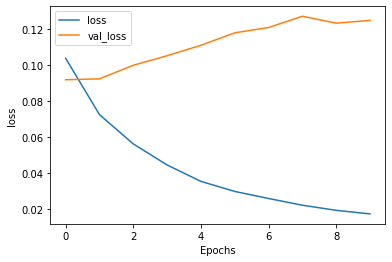

In [16]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "loss")

In [17]:
# # In the future, this random sample method should be changed so that each media has exactly a half of tweets being sampled 
# # into train/test...
# np.random.seed(0)
# sample = list(np.random.randint(2, size=len(labels)))
# train_articles = [articles[i] for i in range(len(sample)) if sample[i] == 1]
# train_labels = [labels[i] for i in range(len(sample)) if sample[i] == 1]
# validation_articles = [articles[i] for i in range(len(sample)) if sample[i] == 0]
# validation_labels = [labels[i] for i in range(len(sample)) if sample[i] == 0]

# print(len(train_articles))
# print(len(train_labels))
# print(len(validation_articles))
# print(len(validation_labels))

In [18]:
# tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(train_articles)
# word_index = tokenizer.word_index
# train_sequences = tokenizer.texts_to_sequences(train_articles)

In [19]:
# train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# validation_sequences = tokenizer.texts_to_sequences(validation_articles)
# validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# training_label_seq = np.array(train_labels)
# validation_label_seq = np.array(validation_labels)

# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [20]:
# model = tf.keras.Sequential([
#     # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
#     tf.keras.layers.Embedding(vocab_size, embedding_dim),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
# #    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     # use ReLU in place of tanh function since they are very good alternatives of each other.
#     tf.keras.layers.Dense(embedding_dim, activation='relu'),
#     # Add a Dense layer with 6 units and softmax activation.
#     # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
#     tf.keras.layers.Dense(1)
# ])
# model.summary()

In [21]:
# model.compile(optimizer='adam', loss='mae')
# num_epochs = 10
# history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

In [22]:
train_predict = model.predict(train_padded)
test_predict = model.predict(validation_padded)

In [23]:
bias_pred = test_predict[:,0]
qual_pred = test_predict[:,1]

In [24]:
# y_true = df_2018[['bias','quality']].to_numpy()
# y_true = y_true[train_size:,:]
# np.linalg.norm(y_true-y_pred)

In [25]:
# y_pred1 = df_2018[['bias','quality']].to_numpy()
# y_pred1 = y_pred1[:train_size,:]
# np.linalg.norm(train_predict-y_pred1, 'fro')

In [26]:
df_test = df_2018.tail(df_2018.shape[0]-train_size)

In [27]:
df_test['bias_pred'] = bias_pred
df_test['qual_pred'] = qual_pred

C:\Users\zchao\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\zchao\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
df_test.head(5)

,user_screen_name,text,created_at,hashtags,bias,quality,bias_pred,qual_pred
16063,TheIJR,Couple Shows ‘Support’ for Hillary with HUGE B...,2016-09-30 18:19:11+00:00,NaN,0.261165,0.694198,0.020276,0.666964
16064,thedailybeast,New York Yankees advance to American League ch...,2017-10-12 11:44:15+00:00,NaN,-0.467543,0.480507,-0.183530,0.692739
16065,TIME,PSY's viral hit song played at the Winter Olym...,2018-02-10 02:15:10+00:00,NaN,-0.168803,0.624044,-0.098424,0.829819
16066,WSJ,Some of the immigrants were in the U.S. illega...,2017-09-29 20:15:08+00:00,NaN,0.073562,0.857640,-0.464667,0.501269
16067,freespeechtv,The American healthcare system is a bureaucrat...,2017-09-18 16:45:14+00:00,THP,-0.727845,0.137081,-0.103461,0.398624


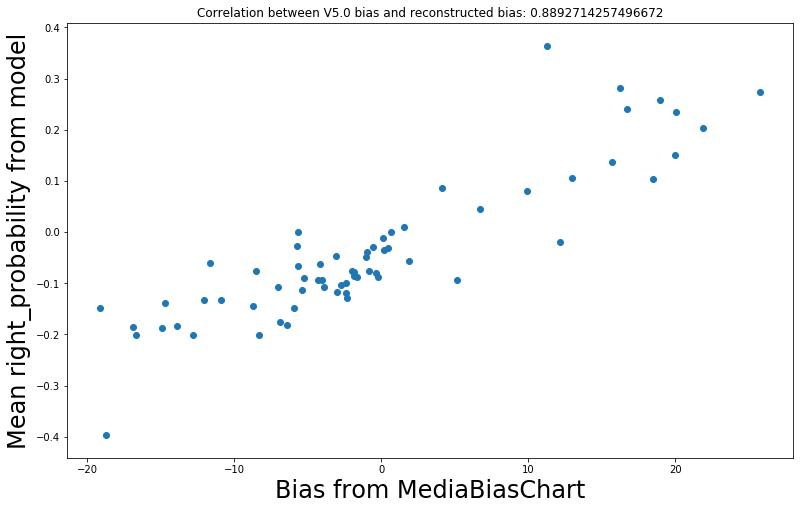

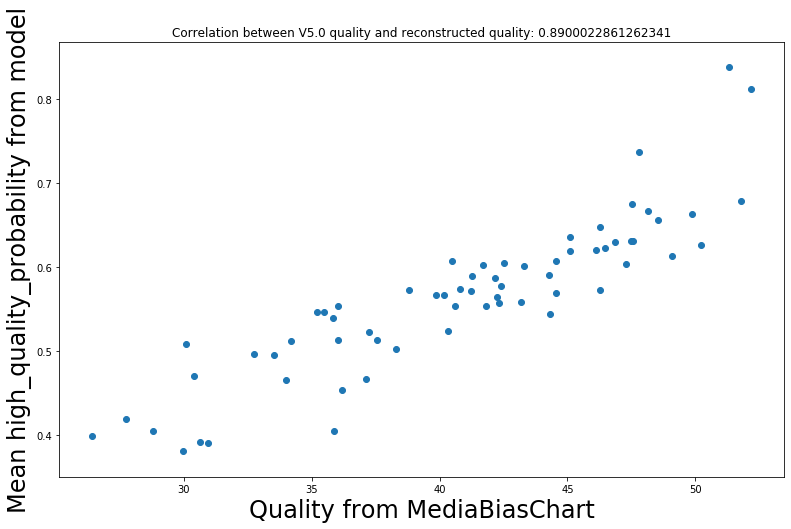

In [39]:
import scipy
media_bias = media_bias.sort_values(by = ['Source'])
average_bias = df_test.groupby(['user_screen_name']).bias_pred.mean()
average_qual = df_test.groupby(['user_screen_name']).qual_pred.mean()
bias = media_bias.Bias
quality = media_bias.Quality

corr_bias = scipy.stats.pearsonr(average_bias.tolist(), bias.tolist())[0]
corr_quality = scipy.stats.pearsonr(average_qual.tolist(), quality.tolist())[0]

plt.figure(figsize=(13, 8))
plt.xlabel('Bias from MediaBiasChart', fontsize=24) 
plt.ylabel('Mean right_probability from model', fontsize=24)
plt.scatter(bias.tolist(), average_bias.tolist())
plt.title('Correlation between V5.0 bias and reconstructed bias: '+str(corr_bias))
plt.savefig('../results/LSTM/biasvs.png')


plt.figure(figsize=(13, 8))
plt.xlabel('Quality from MediaBiasChart', fontsize=24)
plt.ylabel('Mean high_quality_probability from model', fontsize=24)
plt.scatter(quality.tolist(), average_qual.tolist())
plt.title('Correlation between V5.0 quality and reconstructed quality: '+str(corr_quality))
plt.savefig('../results/LSTM/qualvs.png')

In [35]:
average_bias

user_screen_name
ABC              -0.084993
AP               -0.048931
BBC              -0.116666
Bloomberg        -0.076788
BreitbartNews     0.258756
                    ...   
thenation        -0.186140
thinkprogress    -0.148880
voxdotcom        -0.143760
washingtonpost   -0.063062
weatherchannel   -0.100313
Name: bias_pred, Length: 65, dtype: float32

In [38]:
media_bias.sort_values(by = ['Source'])

,Source,Bias,Quality
0,ABC,-1.846000,49.866500
1,AP,-1.063261,52.189130
6,BBC,-3.033333,46.266667
8,Bloomberg,-0.850345,47.522759
9,BreitbartNews,18.987857,30.637143
...,...,...,...
85,thenation,-16.891538,33.544615
89,thinkprogress,-19.116000,35.850000
97,voxdotcom,-8.750000,42.327143
102,washingtonpost,-4.179888,44.567303


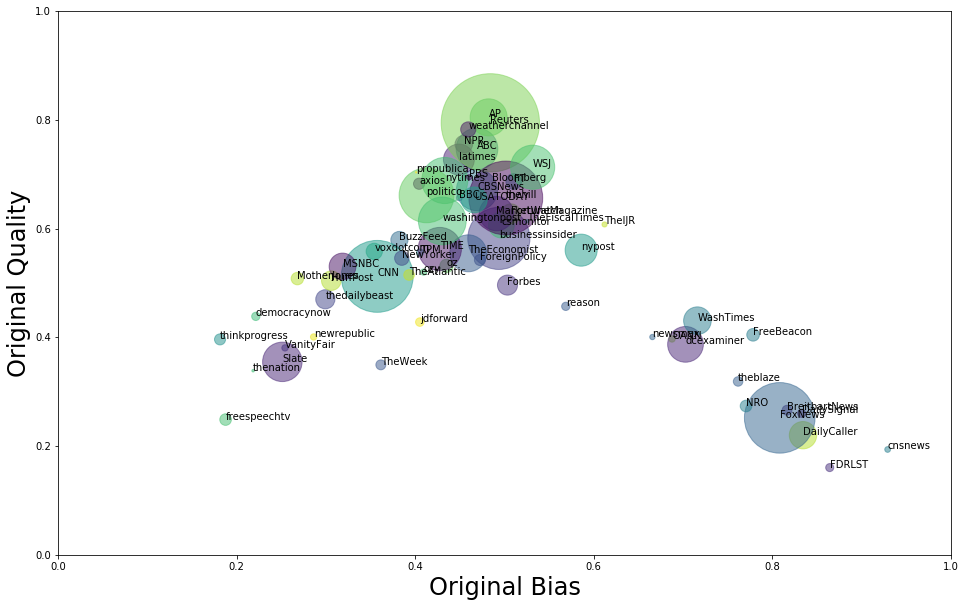

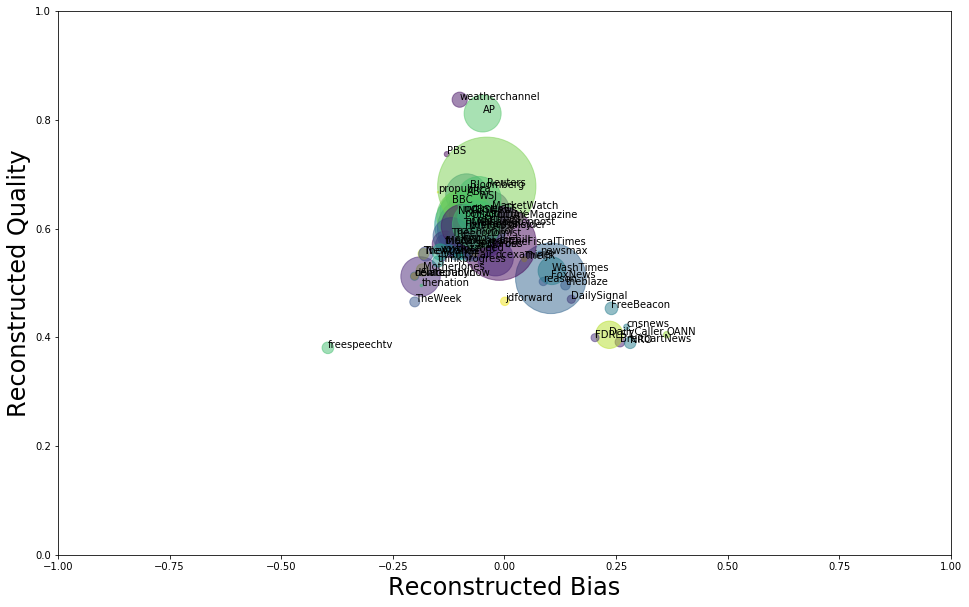

In [31]:
n_tweets = df.groupby(['user_screen_name']).size()
n_tweets = n_tweets.rename("n_tweets")
N = media_bias.shape[0]
np.random.seed(1)
colors = np.random.rand(N)
media_bias = media_bias.set_index('Source').join(average_bias).join(average_qual).join(n_tweets)
media_bias = media_bias.dropna()
media_bias = media_bias.reset_index()

def plotsubset(names, dir1, dir2):
    index = media_bias.Source.isin(names)

    names = media_bias[index].Source.tolist()
    x0 = [(x+30)/60 for x in media_bias[index].Bias.tolist()]
    y0 = [(x-20)/40 for x in media_bias[index].Quality.tolist()]
    x1 = media_bias[index].bias_pred.tolist()
    y1 = media_bias[index].qual_pred.tolist()
    size = [x**2 / 900000 for x in media_bias[index].n_tweets.tolist()]
    color = pd.Series(colors)[index].tolist()
    
    plt.figure(figsize=(16, 10))
    # pd.Series(size)
    plt.scatter(x0, y0, s=size, c=color, alpha=0.5)
    for i, name in enumerate(names):
        plt.annotate(name, (x0[i], y0[i]))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Original Bias', fontsize=24)
    plt.ylabel('Original Quality', fontsize=24)
    plt.savefig(dir1)
    

    plt.figure(figsize=(16, 10))
    for i, name in enumerate(names):
        plt.annotate(name, (x1[i], y1[i]))
    plt.scatter(x1, y1, s=size, c=color, alpha=0.5)
    plt.xlim(-1, 1)
    plt.ylim(0, 1)
    plt.xlabel('Reconstructed Bias', fontsize=24)
    plt.ylabel('Reconstructed Quality', fontsize=24)
    plt.savefig(dir2)

names = media_bias.Source.tolist()
dir1 = '../results/LSTM/media_all_origin.png'
dir2 = '../results/LSTM/media_all_recon.png'
plotsubset(names, dir1, dir2)

In [32]:
media_bias

,Source,Bias,Quality,bias_pred,qual_pred,n_tweets
0,ABC,-1.846000,49.866500,-0.084993,0.662537,39552
1,AP,-1.063261,52.189130,-0.048931,0.811832,35117
2,axios,-5.737857,47.303571,-0.026823,0.603035,10632
3,BBC,-3.033333,46.266667,-0.116666,0.647665,5660
4,Bloomberg,-0.850345,47.522759,-0.076788,0.675009,127
...,...,...,...,...,...,...
60,dcexaminer,12.166250,35.485000,-0.020129,0.545805,33897
61,FreeBeacon,16.708125,36.187500,0.239650,0.453321,12019
62,washingtonpost,-4.179888,44.567303,-0.063062,0.607563,45302
63,WashTimes,12.966667,37.228000,0.106245,0.522460,26215


In [33]:
media_bias = pd.read_csv('../data/MediaBiasChart.csv')
media_bias = media_bias.groupby('Source').mean()
media_bias.reset_index(level=0, inplace=True)

MediaBiasChart_to_Tweet = {'ABC':'ABC','AP':'AP','Axios':'axios','CNN':'CNN','Wall Street Journal':'WSJ',\
    'The Atlantic':'TheAtlantic','The Hill':'thehill', 'BBC':'BBC', 'Think Progress':'thinkprogress',\
    'MSNBC':'MSNBC','The Nation':'thenation','Daily Beast':'thedailybeast','Mother Jones':'MotherJones',\
    'CNSNews':'cnsnews','Fox News':'FoxNews', 'The Federalist':'FDRLST','Breitbart':'BreitbartNews',\
    'Daily Caller':'DailyCaller','The Blaze':'theblaze','Business Insider':'businessinsider',\
    'CBS':'CBSNews','The Economist':'TheEconomist','BuzzFeed':'BuzzFeed','Daily Signal':'DailySignal',\
    'New Republic':'newrepublic','Foreign Policy':'ForeignPolicy','IJR':'TheIJR','National Review':'NRO',\
    'National Public Radio':'NPR','New York Post':'nypost','New York Times':'nytimes','The New Yorker':'NewYorker',\
    'NewsMax':'newsmax','One America News Network':'OANN','Politico':'politico','Quartz':'qz',\
    'Reason':'reason','Reuters':'Reuters','Slate':'Slate','Talking Points Memo':'TPM','Vanity Fair':'VanityFair',\
    'Vox':'voxdotcom','Washington Examiner':'dcexaminer','Washington Free Beacon':'FreeBeacon',\
    'Washington Post':'washingtonpost','Washington Times':'WashTimes','The Week':'TheWeek','Bloomberg':'Bloomberg',\
    'Christian Science Monitor':'csmonitor', 'Democracy Now':'democracynow','Financial Times':'FT',\
    'Fiscal Times':'TheFiscalTimes','Forbes':'Forbes','Fortune':'FortuneMagazine','Forward':'jdforward',\
    'FreeSpeech TV':'freespeechtv','Huffington Post':'HuffPost','LA Times':'latimes','Marketwatch':'MarketWatch',\
    'OZY':'ozy','PBS':'PBS','ProPublica':'propublica','Time':'TIME','USA Today':'USATODAY',\
    'Weather.com':'weatherchannel'}

media_bias['Source'] = media_bias.Source.map(MediaBiasChart_to_Tweet)
media_bias = media_bias.dropna()
media_bias.reset_index(drop=True)

,Source,Bias,Quality
0,ABC,-1.846000,49.866500
1,AP,-1.063261,52.189130
2,axios,-5.737857,47.303571
3,BBC,-3.033333,46.266667
4,Bloomberg,-0.850345,47.522759
...,...,...,...
60,dcexaminer,12.166250,35.485000
61,FreeBeacon,16.708125,36.187500
62,washingtonpost,-4.179888,44.567303
63,WashTimes,12.966667,37.228000
